In [1]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


# Cargar el archivo de texto en un DataFrame
df = pd.read_csv('sell-in.txt.gz', sep='\t')


In [2]:
df.head()

,periodo,customer_id,product_id,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn
0,201701,10234,20524,0,2,0.05300,0.05300
1,201701,10032,20524,0,1,0.13628,0.13628
2,201701,10217,20524,0,1,0.03028,0.03028
3,201701,10125,20524,0,1,0.02271,0.02271
4,201701,10012,20524,0,11,1.54452,1.54452


In [3]:
df.columns

Index(['periodo', 'customer_id', 'product_id', 'plan_precios_cuidados',
       'cust_request_qty', 'cust_request_tn', 'tn'],
      dtype='object')

In [4]:
productos = pd.read_csv('tb_productos.txt', sep='\t')

In [5]:
productos.head()

,cat1,cat2,cat3,brand,sku_size,product_id
0,HC,ROPA LAVADO,Liquido,LIMPIEX,900,20280
1,HC,ROPA LAVADO,Liquido,LIMPIEX,450,20180
2,HC,ROPA LAVADO,Liquido,LIMPIEX,120,20332
3,HC,ROPA LAVADO,Liquido,LIMPIEX,450,20222
4,HC,ROPA LAVADO,Liquido,LIMPIEX,900,20288


Se hace una unión de los datasets

In [6]:
df_merged_i = pd.merge(df, productos, on='product_id', how='inner')

In [7]:
stocks = pd.read_csv('tb_stocks.txt.gz', sep='\t')

In [8]:
stocks.head()

,periodo,product_id,stock_final
0,201810,20524,1.61267
1,201810,20311,2.93657
2,201810,20654,6.83269
3,201810,21005,1.01338
4,201810,20974,0.34595


In [10]:
df_final_i = pd.merge(df_merged_i, stocks, on=['periodo', 'product_id'], how='inner')

In [11]:

df_final_i['periodo'] = pd.to_datetime(df_final_i['periodo'])
df_final_i.set_index('periodo', inplace=True)


In [12]:
df_final_i.head()

,customer_id,product_id,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn,cat1,cat2,cat3,brand,sku_size,stock_final
periodo,,,,,,,,,,,,
1970-01-01 00:00:00.000201810,10190,20524,0,1,0.00757,0.00757,HC,VAJILLA,Cristalino,Importado,500,1.61267
1970-01-01 00:00:00.000201810,10357,20524,0,1,0.03786,0.03786,HC,VAJILLA,Cristalino,Importado,500,1.61267
1970-01-01 00:00:00.000201810,10037,20524,0,1,0.03786,0.03786,HC,VAJILLA,Cristalino,Importado,500,1.61267
1970-01-01 00:00:00.000201810,10009,20524,0,8,0.14385,0.14385,HC,VAJILLA,Cristalino,Importado,500,1.61267
1970-01-01 00:00:00.000201810,10353,20524,0,1,0.02271,0.02271,HC,VAJILLA,Cristalino,Importado,500,1.61267


Comprobacion de la integridad de los datos

In [14]:
# Verificar valores faltantes
print(df_final_i.isnull().sum())

# Identificar valores atípicos
for columna in df_final_i.select_dtypes(include=['number']).columns:
    q1 = df_final_i[columna].quantile(0.25)
    q3 = df_final_i[columna].quantile(0.75)
    rango_intercuartil = q3 - q1
    valores_atipicos = df_final_i[(df_final_i[columna] < q1 - 1.5 * rango_intercuartil) | (df_final_i[columna] > q3 + 1.5 * rango_intercuartil)]
    print(f"Valores atípicos en {columna}: {valores_atipicos.shape[0]}")

customer_id              0
product_id               0
plan_precios_cuidados    0
cust_request_qty         0
cust_request_tn          0
tn                       0
cat1                     0
cat2                     0
cat3                     0
brand                    0
sku_size                 0
stock_final              0
dtype: int64
Valores atípicos en customer_id: 2039
Valores atípicos en product_id: 0
Valores atípicos en plan_precios_cuidados: 11739
Valores atípicos en cust_request_qty: 121115
Valores atípicos en cust_request_tn: 172758
Valores atípicos en tn: 172737
Valores atípicos en sku_size: 59963
Valores atípicos en stock_final: 128206


Análisis exploratorio de variables

In [15]:

import seaborn as sns

# Estadísticas descriptivas para variables numéricas
print(df_final_i.describe())


        customer_id    product_id  plan_precios_cuidados  cust_request_qty  \
count  1.148941e+06  1.148941e+06           1.148941e+06      1.148941e+06   
mean   1.016784e+04  2.042865e+04           1.021723e-02      2.113055e+00   
std    1.396112e+02  3.177636e+02           1.005627e-01      3.453318e+00   
min    1.000100e+04  2.000100e+04           0.000000e+00      1.000000e+00   
25%    1.005200e+04  2.015700e+04           0.000000e+00      1.000000e+00   
50%    1.013000e+04  2.036300e+04           0.000000e+00      1.000000e+00   
75%    1.026200e+04  2.065400e+04           0.000000e+00      2.000000e+00   
max    1.061800e+04  2.127600e+04           1.000000e+00      9.000000e+01   

       cust_request_tn            tn      sku_size   stock_final  
count     1.148941e+06  1.148941e+06  1.148941e+06  1.148941e+06  
mean      4.557609e-01  4.447433e-01  4.388325e+02  2.714763e+01  
std       3.360069e+00  3.218929e+00  7.595060e+02  7.476222e+01  
min       1.000000e-04  1.000

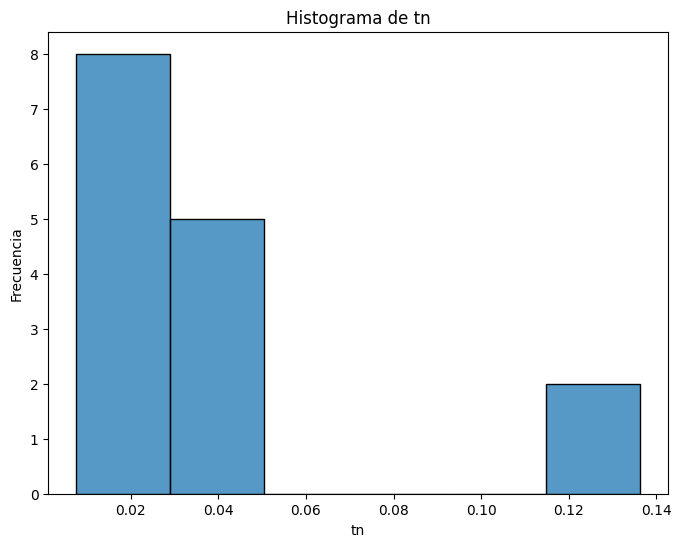

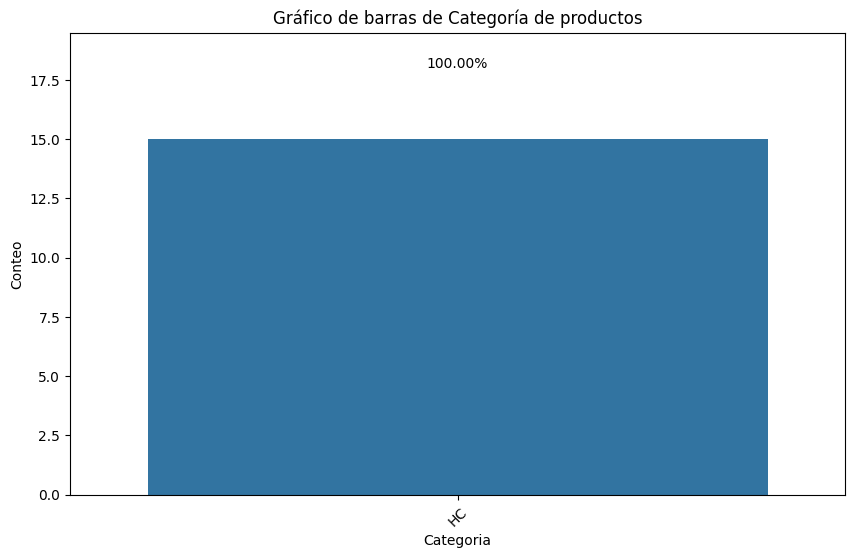

In [17]:
df_final_i = df_final_i[~df_final_i.index.duplicated(keep='first')]


# Histograma para una variable numérica
plt.figure(figsize=(8, 6))
sns.histplot(data=df_final_i, x='tn')
plt.title('Histograma de tn')  # Título del gráfico
plt.xlabel('tn')  # Etiqueta del eje x
plt.ylabel('Frecuencia')  # Etiqueta del eje y
plt.show()

plt.figure(figsize=(10, 6))
ax = sns.countplot(x='cat1', data=df_final_i)
plt.title('Gráfico de barras de Categoría de productos')  # Título del gráfico
plt.xlabel('Categoria')  # Etiqueta del eje x
plt.ylabel('Conteo')  # Etiqueta del eje y
plt.xticks(rotation=45)

total = len(df_final_i)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center") 

# Ajusta los límites del eje y
ax.set_ylim(0, 1.3*df_final_i['cat1'].value_counts().max())

plt.show()

Análisis de relaciones

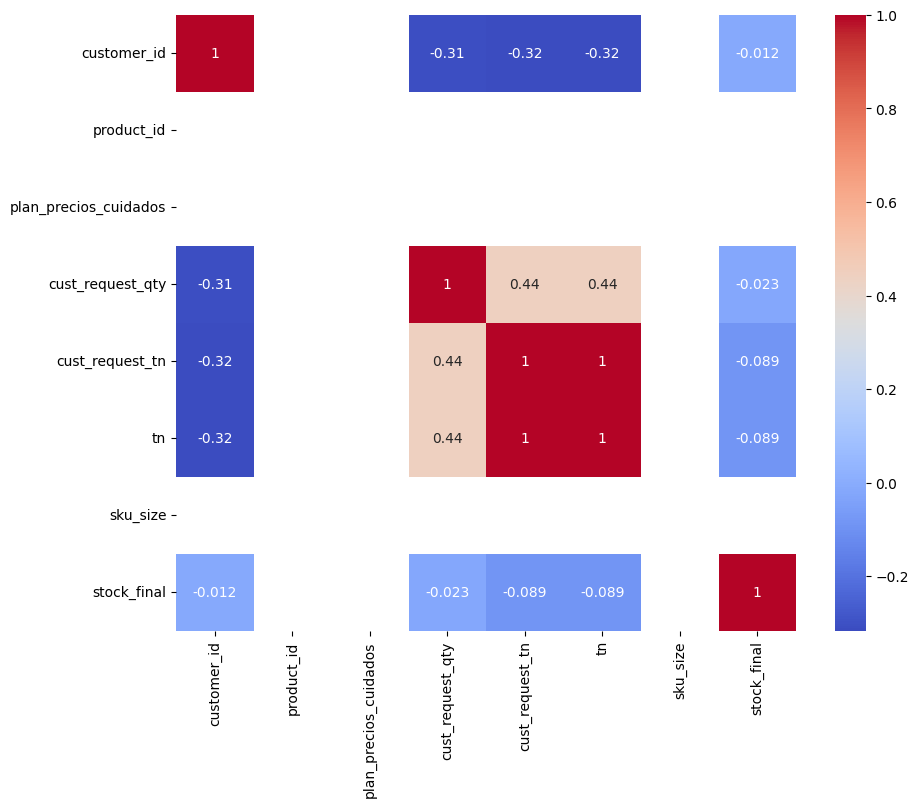

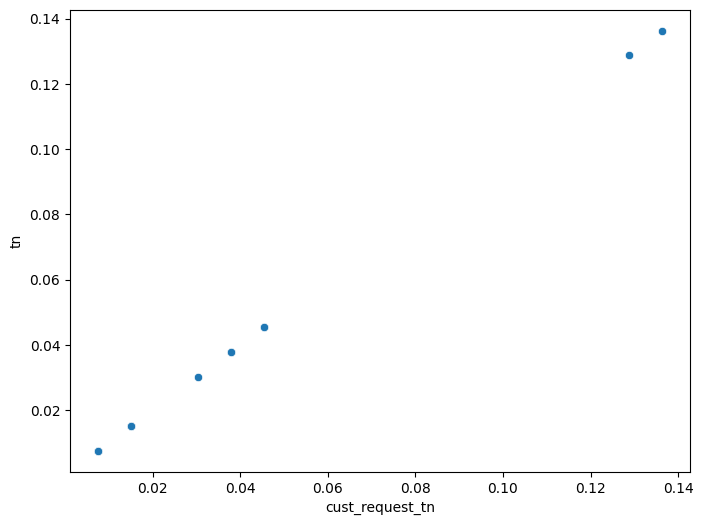

In [18]:
# Matriz de correlación
correlaciones = df_final_i.select_dtypes(include=['number']).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlaciones, annot=True, cmap='coolwarm')
plt.show()

# Gráfico de dispersión
plt.figure(figsize=(8, 6))
sns.scatterplot(x='cust_request_tn', y='tn', data=df_final_i)
plt.show()


Análisis de tendencia y estacionalidad

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Crear serie de tiempo de ventas totales
ventas_totales = df_final_i.groupby('periodo')['tn'].sum()

# Descomposición de la serie de tiempo
descomposicion = seasonal_decompose(ventas_totales, model='multiplicative', period=12)  # Periodo de 12 meses para estacionalidad anual

# Graficar componentes de la serie
descomposicion.plot()
plt.show()

ValueError: x must have 2 complete cycles requires 24 observations. x only has 15 observation(s)

c:\Users\marce\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\marce\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


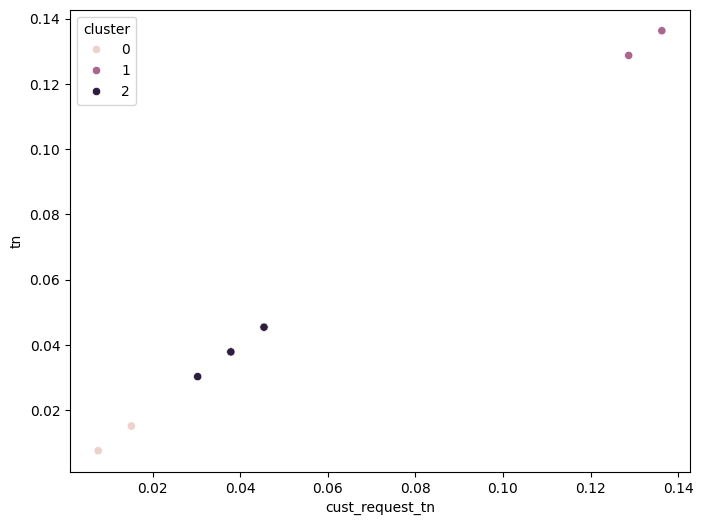

In [20]:
from sklearn.cluster import KMeans

# Seleccionar características relevantes
caracteristicas = df_final_i[['tn', 'cust_request_tn',]]

# Aplicar k-means clustering
kmeans = KMeans(n_clusters=3, random_state=42).fit(caracteristicas)

# Agregar etiquetas de cluster a los datos
df_final_i['cluster'] = kmeans.labels_

# Visualizar clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x='cust_request_tn', y='tn', data=df_final_i, hue='cluster')
plt.show()

Ventas por Categoría 1:
  cat1       tn
0   HC  0.55269


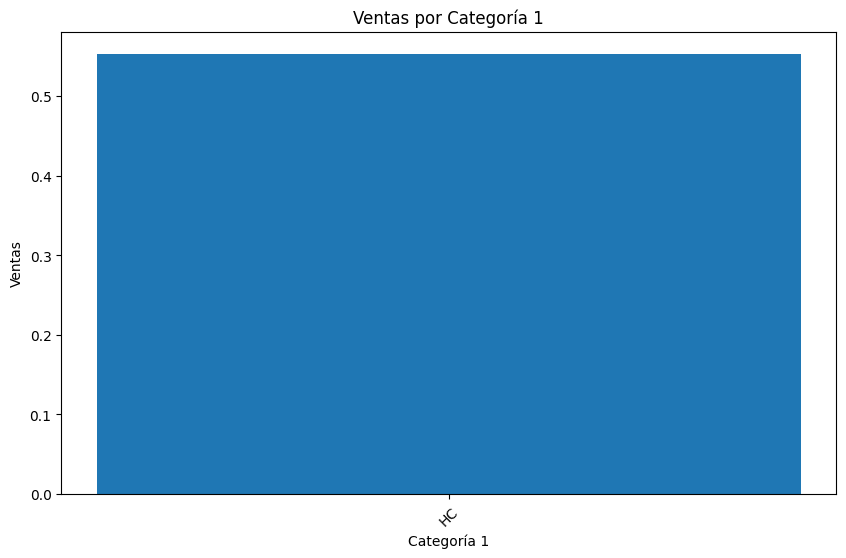


Ventas por Categoría 2:
      cat2       tn
0  VAJILLA  0.55269


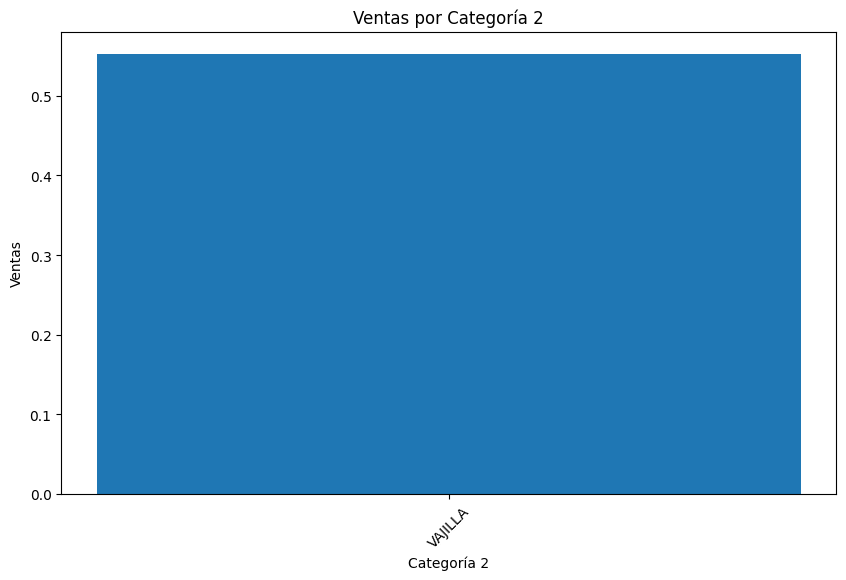


Ventas por Categoría 3:
         cat3       tn
0  Cristalino  0.55269


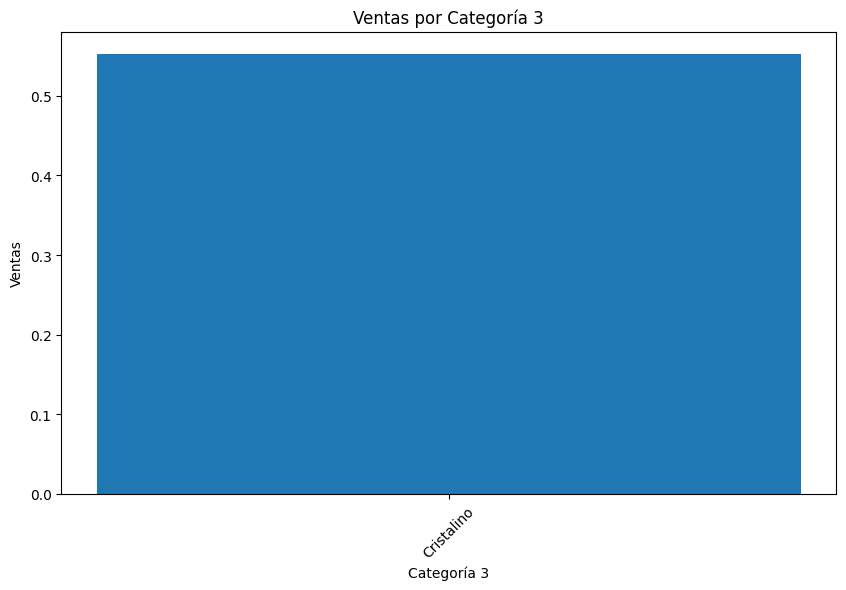


Ventas por Marca:
       brand       tn
0  Importado  0.55269


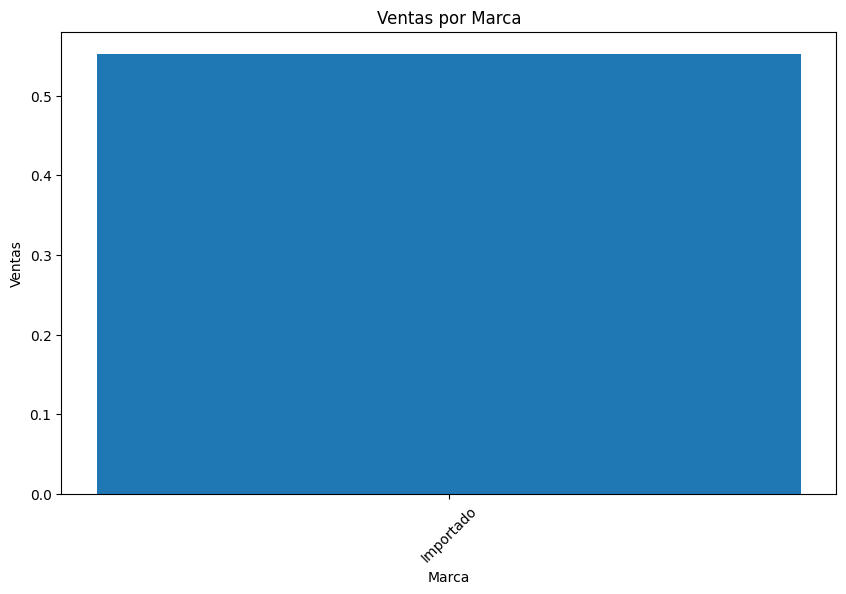


Ventas agrupadas por Categoría 1, Categoría 2 y Marca:
  cat1     cat2      brand       tn
0   HC  VAJILLA  Importado  0.55269


In [21]:



# Agrupar las ventas (tn) por categoría 1
ventas_cat1 = df_final_i.groupby('cat1')['tn'].sum().reset_index()
print("Ventas por Categoría 1:")
print(ventas_cat1)

# Gráfico de ventas por categoría 1
plt.figure(figsize=(10, 6))
plt.bar(ventas_cat1['cat1'], ventas_cat1['tn'])
plt.xlabel('Categoría 1')
plt.ylabel('Ventas')
plt.title('Ventas por Categoría 1')
plt.xticks(rotation=45)
plt.show()

# Agrupar las ventas (tn) por categoría 2
ventas_cat2 = df_final_i.groupby('cat2')['tn'].sum().reset_index()
print("\nVentas por Categoría 2:")
print(ventas_cat2)

# Gráfico de ventas por categoría 2
plt.figure(figsize=(10, 6))
plt.bar(ventas_cat2['cat2'], ventas_cat2['tn'])
plt.xlabel('Categoría 2')
plt.ylabel('Ventas')
plt.title('Ventas por Categoría 2')
plt.xticks(rotation=45)
plt.show()

# Agrupar las ventas (tn) por categoría 3
ventas_cat3 = df_final_i.groupby('cat3')['tn'].sum().reset_index()
print("\nVentas por Categoría 3:")
print(ventas_cat3)

# Gráfico de ventas por categoría 3
plt.figure(figsize=(10, 6))
plt.bar(ventas_cat3['cat3'], ventas_cat3['tn'])
plt.xlabel('Categoría 3')
plt.ylabel('Ventas')
plt.title('Ventas por Categoría 3')
plt.xticks(rotation=45)
plt.show()

# Agrupar las ventas (tn) por marca
ventas_marca = df_final_i.groupby('brand')['tn'].sum().reset_index()
print("\nVentas por Marca:")
print(ventas_marca)

# Gráfico de ventas por marca
plt.figure(figsize=(10, 6))
plt.bar(ventas_marca['brand'], ventas_marca['tn'])
plt.xlabel('Marca')
plt.ylabel('Ventas')
plt.title('Ventas por Marca')
plt.xticks(rotation=45)
plt.show()

# Agrupar las ventas (tn) por categoría 1, categoría 2 y marca
ventas_agrupadas = df_final_i.groupby(['cat1', 'cat2', 'brand'])['tn'].sum().reset_index()
print("\nVentas agrupadas por Categoría 1, Categoría 2 y Marca:")
print(ventas_agrupadas)